image scene classification



In [123]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import mixed_precision
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix

%matplotlib inline

In [33]:
#policy = mixed_precision.Policy('mixed_float16')
#mixed_precision.set_global_policy(policy)

In [48]:
data_folder = 'F:/data-extract/image-scene-classification/'
model_folder = 'g:/model-folder/'
save_model_folder = 'g:/save-model/'
train_path = data_folder + 'train/'
test_path = data_folder + 'test/'
predict_path = data_folder + 'pred/'
image_size1 = (128, 128)
image_size2 = (224, 224)
validation_size = 0.25
validation_size2 = 0.1
batch_size = 32
seed_number = 53
seed_number2 = 261
num_classes = 6
epochs = 8
file_version_num = '001'
model_file = model_folder + 'image scene classification ' + file_version_num + '.h5'
model_file_tune = model_folder + 'image scene classification ' + file_version_num + '-t.h5'
model_file_tune2 = model_folder + 'image scene classification ' + file_version_num + '-t2.h5'
model_file_tune3 = model_folder + 'image scene classification ' + file_version_num + '-t3.h5'

In [49]:
train_ds1 = keras.preprocessing.image_dataset_from_directory(
    train_path,
    validation_split=validation_size,
    subset="training",
    label_mode='categorical',
    seed=seed_number,
    image_size=image_size1,
    batch_size=batch_size, 
    shuffle=True
)

val_ds1 = keras.preprocessing.image_dataset_from_directory(
    train_path,
    validation_split=validation_size,
    subset="validation",
    label_mode='categorical',
    seed=seed_number,
    image_size=image_size1,
    batch_size=batch_size,
    shuffle=True
)


train_ds2 = keras.preprocessing.image_dataset_from_directory(
    train_path,
    validation_split=validation_size,
    subset="training",
    label_mode='categorical',
    seed=seed_number,
    image_size=image_size2,
    batch_size=batch_size, 
    shuffle=True
)

val_ds2 = keras.preprocessing.image_dataset_from_directory(
    train_path,
    validation_split=validation_size,
    subset="validation",
    label_mode='categorical',
    seed=seed_number,
    image_size=image_size2,
    batch_size=batch_size,
    shuffle=True
)


train_ds3 = keras.preprocessing.image_dataset_from_directory(
    train_path,
    validation_split=validation_size2,
    subset="training",
    label_mode='categorical',
    seed=seed_number2,
    image_size=image_size2,
    batch_size=batch_size, 
    shuffle=True
)

val_ds3 = keras.preprocessing.image_dataset_from_directory(
    train_path,
    validation_split=validation_size2,
    subset="validation",
    label_mode='categorical',
    seed=seed_number2,
    image_size=image_size2,
    batch_size=batch_size,
    shuffle=True
)

Found 14034 files belonging to 6 classes.
Using 10526 files for training.
Found 14034 files belonging to 6 classes.
Using 3508 files for validation.
Found 14034 files belonging to 6 classes.
Using 10526 files for training.
Found 14034 files belonging to 6 classes.
Using 3508 files for validation.
Found 14034 files belonging to 6 classes.
Using 12631 files for training.
Found 14034 files belonging to 6 classes.
Using 1403 files for validation.


In [5]:
def plot_history(history):
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [6]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal", seed=37),
        layers.experimental.preprocessing.RandomRotation(0.2, seed=121),
        layers.experimental.preprocessing.RandomZoom(0.2, seed=91),
        layers.experimental.preprocessing.RandomTranslation(0.3, 0.3, seed=79),
        #layers.experimental.preprocessing.Rescaling(1.0 / 255)
    ]
)

In [7]:
base_model = tf.keras.applications.ResNet50V2(input_shape=image_size1 + (3,),
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False

In [8]:
def make_model(input_shape, numclass):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    #x = inputs


    x = base_model(x)
    x = keras.layers.GlobalAveragePooling2D()(x)
    

    if numclass == 2:
        #activation = "sigmoid"
        #units = 1
        activation = "softmax"
        units = numclass
    else:
        activation = "softmax"
        units = numclass

    x = layers.Dropout(0.4)(x)
    x = layers.Dense(1024, activation="relu")(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(1024, activation="relu")(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


In [46]:
tf.keras.backend.clear_session()

In [10]:
model = make_model(input_shape=image_size1 + (3,), numclass=num_classes)
#keras.utils.plot_model(model, show_shapes=True)

In [11]:
callbacks = [
    keras.callbacks.ModelCheckpoint(filepath=save_model_folder+"image_scene_" + file_version_num + "_save_at_{epoch}.h5", save_freq='epoch'),
#    keras.callbacks.TensorBoard(log_dir='g:/logs')
]

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

In [12]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 128, 128, 3)       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 128, 128, 3)       0         
_________________________________________________________________
resnet50v2 (Functional)      (None, 4, 4, 2048)        23564800  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              209817

In [13]:
#history = model.fit(train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds)
history = model.fit(train_ds1, epochs=epochs, validation_data=val_ds1)

Epoch 1/8
329/329 [==============================] - 25s 64ms/step - loss: 1.3394 - accuracy: 0.5655 - val_loss: 0.4809 - val_accuracy: 0.8127
Epoch 2/8
329/329 [==============================] - 19s 59ms/step - loss: 0.8300 - accuracy: 0.6953 - val_loss: 0.4089 - val_accuracy: 0.8469
Epoch 3/8
329/329 [==============================] - 20s 59ms/step - loss: 0.7735 - accuracy: 0.7171 - val_loss: 0.4149 - val_accuracy: 0.8452
Epoch 4/8
329/329 [==============================] - 20s 59ms/step - loss: 0.7595 - accuracy: 0.7239 - val_loss: 0.4069 - val_accuracy: 0.8481
Epoch 5/8
329/329 [==============================] - 20s 59ms/step - loss: 0.7567 - accuracy: 0.7282 - val_loss: 0.4130 - val_accuracy: 0.8355
Epoch 6/8
329/329 [==============================] - 20s 59ms/step - loss: 0.7457 - accuracy: 0.7220 - val_loss: 0.4001 - val_accuracy: 0.8498
Epoch 7/8
329/329 [==============================] - 20s 59ms/step - loss: 0.7235 - accuracy: 0.7317 - val_loss: 0.3795 - val_accuracy: 0.8529

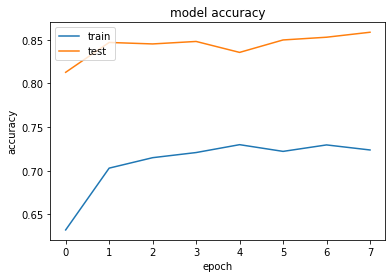

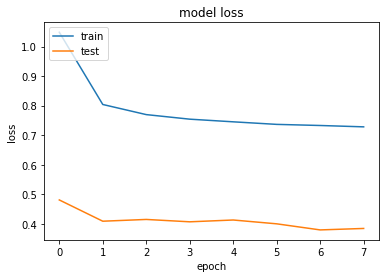

In [14]:
plot_history(history)

In [15]:
model.save(model_file)

fine tune

In [16]:
def make_model_fine(input_shape, numclass):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    #x = inputs

    # Fine-tune from this layer onwards
    #fine_tune_at = 100

    # Freeze all the layers before the `fine_tune_at` layer
    #for layer in base_model.layers[:fine_tune_at]:
    #    layer.trainable =  False


    x = base_model(x)

    #for layer in base_model.layers[-20:]:
    #    print(layer)

    #x = layers.Conv2D(3382,3)(x)
    #x = layers.MaxPooling2D(2)(x)
    #x = layers.Conv2D(256,3)(x)
    x = keras.layers.GlobalAveragePooling2D()(x)
    

    if numclass == 2:
        #activation = "sigmoid"
        #units = 1
        activation = "softmax"
        units = numclass
    else:
        activation = "softmax"
        units = numclass

    x = layers.Dropout(0.4)(x)
    x = layers.Dense(1024, activation="relu")(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(1024, activation="relu")(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


In [24]:
input_shape = image_size2 + (3,)
base_model = tf.keras.applications.ResNet50V2(input_shape=input_shape,
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False

model_fine1 = make_model_fine(input_shape=input_shape, numclass=num_classes)
model_fine1.load_weights(model_file)

#base_model.trainable = True

model_fine1.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

In [25]:
historyf1 = model_fine1.fit(train_ds2, epochs=epochs+4, validation_data=val_ds2)

Epoch 1/12
329/329 [==============================] - 40s 115ms/step - loss: 0.5854 - accuracy: 0.7889 - val_loss: 0.3045 - val_accuracy: 0.8888
Epoch 2/12
329/329 [==============================] - 38s 114ms/step - loss: 0.5880 - accuracy: 0.7837 - val_loss: 0.3036 - val_accuracy: 0.8928
Epoch 3/12
329/329 [==============================] - 38s 115ms/step - loss: 0.5414 - accuracy: 0.8067 - val_loss: 0.3069 - val_accuracy: 0.8917
Epoch 4/12
329/329 [==============================] - 38s 114ms/step - loss: 0.5455 - accuracy: 0.8024 - val_loss: 0.3033 - val_accuracy: 0.8974
Epoch 5/12
329/329 [==============================] - 38s 114ms/step - loss: 0.5318 - accuracy: 0.8067 - val_loss: 0.2923 - val_accuracy: 0.8951
Epoch 6/12
329/329 [==============================] - 38s 115ms/step - loss: 0.5283 - accuracy: 0.8059 - val_loss: 0.2842 - val_accuracy: 0.8999
Epoch 7/12
329/329 [==============================] - 38s 115ms/step - loss: 0.5377 - accuracy: 0.8068 - val_loss: 0.2897 - val_ac

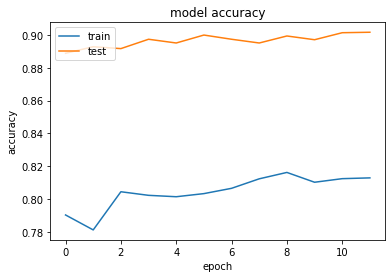

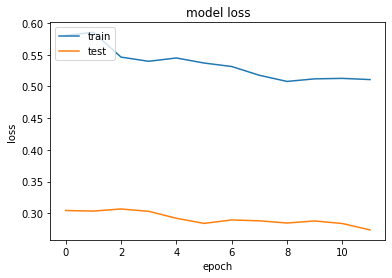

In [26]:
plot_history(historyf1)

In [27]:
model_fine1.save(model_file_tune)

fine tune 2

In [41]:
input_shape = image_size2 + (3,)
base_model = tf.keras.applications.ResNet50V2(input_shape=input_shape,
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False

model_fine2 = make_model_fine(input_shape=input_shape, numclass=num_classes)
model_fine2.load_weights(model_file_tune)

base_model.trainable = True

model_fine2.compile(
    optimizer=keras.optimizers.Adam(1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

In [37]:
historyf2 = model_fine2.fit(train_ds2, epochs=epochs+10, validation_data=val_ds2)

Epoch 1/18
329/329 [==============================] - 84s 243ms/step - loss: 0.7689 - accuracy: 0.7516 - val_loss: 0.2901 - val_accuracy: 0.8988
Epoch 2/18
329/329 [==============================] - 81s 247ms/step - loss: 0.5162 - accuracy: 0.8187 - val_loss: 0.2888 - val_accuracy: 0.8999
Epoch 3/18
329/329 [==============================] - 83s 252ms/step - loss: 0.4683 - accuracy: 0.8390 - val_loss: 0.2704 - val_accuracy: 0.9071
Epoch 4/18
329/329 [==============================] - 85s 257ms/step - loss: 0.4212 - accuracy: 0.8561 - val_loss: 0.2624 - val_accuracy: 0.9102
Epoch 5/18
329/329 [==============================] - 85s 257ms/step - loss: 0.3945 - accuracy: 0.8631 - val_loss: 0.2623 - val_accuracy: 0.9102
Epoch 6/18
329/329 [==============================] - 86s 260ms/step - loss: 0.3637 - accuracy: 0.8724 - val_loss: 0.2482 - val_accuracy: 0.9111
Epoch 7/18
329/329 [==============================] - 86s 260ms/step - loss: 0.3461 - accuracy: 0.8808 - val_loss: 0.2421 - val_ac

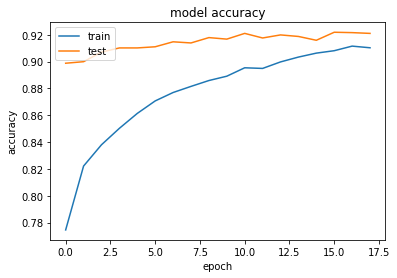

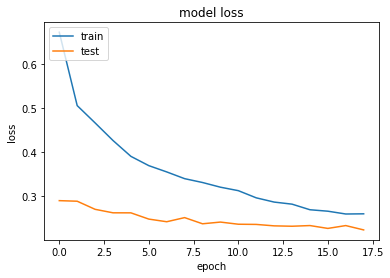

In [52]:
plot_history(historyf2)

In [39]:
model_fine2.save(model_file_tune2)

fine tune 3

swap train & val

In [50]:
input_shape = image_size2 + (3,)
base_model = tf.keras.applications.ResNet50V2(input_shape=input_shape,
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = True

model_fine3 = make_model_fine(input_shape=input_shape, numclass=num_classes)
model_fine3.load_weights(model_file_tune2)

base_model.trainable = True

model_fine3.compile(
    optimizer=keras.optimizers.Adam(1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

In [51]:
historyf3 = model_fine3.fit(train_ds3, epochs=epochs+10, validation_data=val_ds3)

Epoch 1/18
395/395 [==============================] - 98s 238ms/step - loss: 0.2772 - accuracy: 0.9064 - val_loss: 0.1561 - val_accuracy: 0.9387
Epoch 2/18
395/395 [==============================] - 95s 239ms/step - loss: 0.2659 - accuracy: 0.9096 - val_loss: 0.1504 - val_accuracy: 0.9451
Epoch 3/18
395/395 [==============================] - 99s 249ms/step - loss: 0.2495 - accuracy: 0.9151 - val_loss: 0.1555 - val_accuracy: 0.9437
Epoch 4/18
395/395 [==============================] - 99s 250ms/step - loss: 0.2468 - accuracy: 0.9148 - val_loss: 0.1558 - val_accuracy: 0.9487
Epoch 5/18
395/395 [==============================] - 99s 250ms/step - loss: 0.2382 - accuracy: 0.9129 - val_loss: 0.1565 - val_accuracy: 0.9401
Epoch 6/18
395/395 [==============================] - 98s 247ms/step - loss: 0.2426 - accuracy: 0.9211 - val_loss: 0.1540 - val_accuracy: 0.9416
Epoch 7/18
395/395 [==============================] - 97s 246ms/step - loss: 0.2303 - accuracy: 0.9213 - val_loss: 0.1540 - val_ac

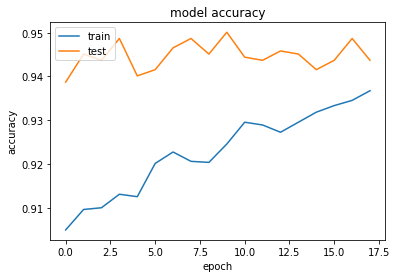

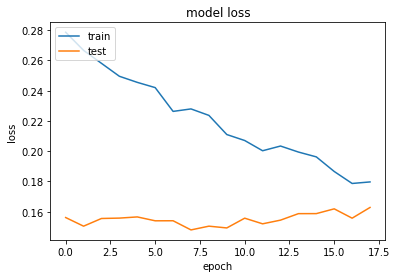

In [53]:
plot_history(historyf3)

In [54]:
model_fine3.save(model_file_tune3)

make prediction

In [55]:
test_ds = keras.preprocessing.image_dataset_from_directory(
    test_path,
    label_mode='categorical',
    seed=seed_number,
    image_size=image_size2,
    batch_size=batch_size, 
    shuffle=True
)

Found 3000 files belonging to 6 classes.


In [57]:
eval3 = model_fine3.evaluate(test_ds)

94/94 [==============================] - 8s 82ms/step - loss: 0.2084 - accuracy: 0.9323


In [59]:
eval3

[0.20835165679454803, 0.9323333501815796]

In [62]:
pred3 = model_fine3.predict(test_ds)

In [78]:
pred3

array([[3.5492728e-06, 3.1101027e-14, 9.2741670e-10, 2.3526940e-14,
        3.9175575e-13, 9.9999642e-01],
       [1.2056458e-01, 1.4439651e-07, 6.7619716e-05, 3.3254112e-06,
        1.5157989e-05, 8.7934911e-01],
       [2.6308862e-16, 5.2873358e-17, 9.9852282e-01, 1.4771987e-03,
        9.6114929e-09, 2.9986267e-14],
       ...,
       [1.2286920e-14, 4.0042344e-14, 9.9603480e-01, 3.9649932e-03,
        2.8611370e-07, 6.9469056e-13],
       [6.7371009e-05, 2.0684301e-13, 8.0543376e-09, 8.0486581e-12,
        1.1571101e-10, 9.9993265e-01],
       [7.1279263e-01, 5.2156552e-06, 5.2764290e-04, 1.3357260e-05,
        3.6823627e-04, 2.8629291e-01]], dtype=float32)

In [111]:
datagen = ImageDataGenerator()

In [112]:
imgtest = datagen.flow_from_directory(
    test_path,
    target_size=image_size2,
    classes=None,
    class_mode="categorical",
    batch_size=batch_size,
    shuffle=False,
    seed=seed_number)

Found 3000 images belonging to 6 classes.


In [127]:
imgclass = imgtest.classes
imgclass

array([0, 0, 0, ..., 5, 5, 5])

In [116]:
pred3 = model_fine3.predict(imgtest)

In [117]:
pred3[0]

array([1.0000000e+00, 2.6965758e-20, 1.4252189e-13, 2.6726048e-18,
       4.7117614e-12, 1.2383344e-09], dtype=float32)

In [121]:
print(imgclass[1700], pred3[1700])

3 [2.5086467e-07 9.2791624e-06 1.4865738e-01 8.5123312e-01 9.9721488e-05
 1.8933046e-07]


(-0.5, 223.5, 223.5, -0.5)

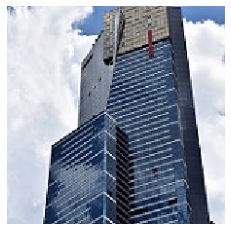

In [114]:
plt.figure()
#ax = plt.subplot(3, 3, i + 1)
plt.imshow(imgtest[0][0][0].astype("uint8"))
#plt.title(int(labels[i]))
plt.axis("off")

In [126]:
confusion_matrix(imgclass, np.argmax(pred3, axis=1))

array([[415,   1,   0,   0,   1,  20],
       [  2, 470,   0,   1,   1,   0],
       [ 18,   3, 432,  85,  15,   0],
       [ 23,   3,  26, 456,  17,   0],
       [ 24,   5,   2,   4, 474,   1],
       [ 37,   0,   0,   1,   2, 461]], dtype=int64)

In [133]:
imgtest.class_indices

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

In [134]:
target_names = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
classification_report(imgclass, np.argmax(pred3, axis=1), target_names=target_names)

'              precision    recall  f1-score   support\n\n   buildings       0.80      0.95      0.87       437\n      forest       0.98      0.99      0.98       474\n     glacier       0.94      0.78      0.85       553\n    mountain       0.83      0.87      0.85       525\n         sea       0.93      0.93      0.93       510\n      street       0.96      0.92      0.94       501\n\n    accuracy                           0.90      3000\n   macro avg       0.91      0.91      0.90      3000\nweighted avg       0.91      0.90      0.90      3000\n'

					precision    recall  f1-score   support
				buildings       0.80      0.95      0.87       437
				forest       	0.98      0.99      0.98       474
				glacier       	0.94      0.78      0.85       553
				mountain       	0.83      0.87      0.85       525
				sea     	0.93      0.93      0.93       510
				street       	0.96      0.92      0.94       501

				accuracy                           0.90      3000
				macro avg       0.91      0.91      0.90      3000
				weighted avg       0.91      0.90      0.90      3000